# Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [1]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning

Скачаем данные

In [2]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwxr-xr-x 3 root root 4096 Dec 11 10:03 __MACOSX
---------- 1 root root  263 Dec 11 10:02 __notebook_source__.ipynb
drwx------ 4 root root 4096 Nov 26 08:32 data


Посмотрим как выглядит один из файлов разметки

In [3]:
!cat data/train/apple_3.xml

<annotation>
	<folder>train</folder>
	<filename>apple_3.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_3.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>708</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<obj

## Релизуйте выборку для YoloV1 - 2 балла

In [3]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict
import re
import math
import random

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch
from albumentations.pytorch import ToTensorV2

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import auc
from collections import Counter
# Добавьте необходимые вам библиотеки, если их не окажется в списке выше

In [4]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123)

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [5]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.image_paths = [data_dir + '/' + f for f in sorted(os.listdir(data_dir)) if f.split('.')[1] == 'jpg']
        self.box_paths = [data_dir + '/' + f for f in sorted(os.listdir(data_dir)) if f.split('.')[1] == 'xml']

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        # image = (np.array(Image.open(self.image_paths[idx]).convert("RGB")) / 255 - 0.5) * 2
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB")) 
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx], image.shape[1], image.shape[0])
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, class_labels=class_labels)
            image = transformed['image']
            boxes = transformed['bboxes']
            class_labels = transformed['class_labels']
        
        else:
            image = torch.Tensor(image)
            boxes = torch.Tensor(boxes)
        
        return image, (boxes, class_labels)

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str, width, height):
        """
          Метод, который считает и распарсит (с помощью xmltodict) переданный xml
          файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
          и название класса обьекта в каждом прямоугольнике

          Обратите внимание, что обьектов может быть как несколько, так и один единственный
        """
        boxes = []
        class_labels = []

        with open(xml_filename) as f:
            dict_of_bbox = xmltodict.parse(f.read())

        if type(dict_of_bbox['annotation']['object']) is list:
            for obj in dict_of_bbox['annotation']['object']:
                box = [int(num) for num in list(obj['bndbox'].values())]
                yolo_box = self.__convert_to_yolo_box_params(box, width, height)
                boxes += [yolo_box]
                class_labels += [class2tag[obj['name']]]
        
        else:
            box = [int(num) for num in  list(dict_of_bbox['annotation']['object']['bndbox'].values())]
            yolo_box = self.__convert_to_yolo_box_params(box, width, height)
            boxes += [yolo_box]
            class_labels += [class2tag[dict_of_bbox['annotation']['object']['name']]]
      
        return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
        
        """
          Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].

          Обратите внимание, что параметры [x_center, y_center, width, height] - это
          относительные значение в отрезке [0, 1]

          :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
          :param: im_w - ширина исходного изображения
          :param: im_h - высота исходного изображения

          :return: координаты коробки в формате [x_center, y_center, width, height]
        """
        ans = []

        ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
        ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
    
        ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
        ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
        return ans

In [6]:
WIDTH, HEIGHT = 448, 448

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

train_transform = A.Compose([A.Resize(HEIGHT, WIDTH),
                             A.OneOf([
                                 A.HorizontalFlip(p=1),
                                 A.RandomRotate90(p=1),
                                 A.VerticalFlip(p=1)
                                 ], p=0.5),
                             A.OneOf([
                                 A.RandomBrightnessContrast(p=1),
                                 A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=1),
                                 A.ToGray (p=1)
                                 ], p=0.3),
                             A.OneOf([
                                     A.Blur(blur_limit=(7 ,11), p=1),
                                     A.MedianBlur(blur_limit=(7 ,11), p=1)
                                     ], p=0.2),
                             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                             ToTensorV2()],
                             bbox_params=A.BboxParams(format='yolo',
                                                      label_fields=['class_labels']))
test_transform = A.Compose([A.Resize(HEIGHT, WIDTH),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2()],
                            bbox_params=A.BboxParams(format='yolo',
                                                     label_fields=['class_labels']))

In [7]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="/kaggle/working/data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="/kaggle/working/data/test"
    )

# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
assert isinstance(train_dataset[0][1], tuple)
assert len(train_dataset[0][1]) == 2
print("Тесты успешно пройдены")

Тесты успешно пройдены


**Batch_collate_fn** я взял с [Ara Intelligence Blog](https://araintelligence.com/blogs/deep-learning/object-detection/yolo_v1), где поясняется за устройство **YOLO**. 

Эта функция потом поможет в подсчета  **Loss`а**.

In [8]:
grid_size = 7
examples_per_cell = 2
nums_of_classes = 3

def batch_collate_fn(batch):    
    images = [item[0].unsqueeze(0) for item in batch]    
    detections = []
    for item in batch:
        det = item[1]
        det = zip(det[0], det[1])
        image_detections = torch.zeros(1, grid_size, grid_size, 5*examples_per_cell + nums_of_classes)
        for box, cls in det:            
            gx = math.floor(grid_size * box[0])
            gy = math.floor(grid_size * box[1])
            for i in range(0, 5*examples_per_cell, 5):
                image_detections[0, gx, gy, i:i+4] = torch.tensor([grid_size * box[0] - gx, grid_size * box[1] - gy] + list(box[2:4]))
                image_detections[0, gx, gy, i+4] = 1
            image_detections[0, gx, gy, 5*examples_per_cell + cls - 1] = 1
        detections.append(image_detections)

    images = torch.cat(images, 0)
    detections = torch.cat(detections, 0)    
    return (images, detections)


train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=batch_collate_fn)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4, 
    shuffle=False,
    collate_fn=batch_collate_fn
    )

Давайте в начале вообще посмотрим как данные выглядят и правильно ли мы организовали лоадер и датасет.

In [9]:
def get_true_boxes(loader, grid_size=7, examples_per_cell=2, nums_of_classes=3):
    """ 
        Args:
            loader: (Tensor) размер [N, n_batches, S, S, 5xB+C], 5=len([x, y, w, h, conf]).
            iou_threshold: (float).
            threshold: (float)
        Returns:
            (List): bboxes_from_batch, sized [n_boxes_i, 9] 9=(len([batch_num, xmin, ymin, xmax, ymax, conf, prob_class1, prob_class2, prob_class3])).
    """
    all_true_boxes = torch.tensor([])

    train_idx = 0

    for batch_idx, (x, true_boxes) in enumerate(loader):
        true_boxes = true_boxes # [S, S, 5xB+C]

        batch_size = x.shape[0]

        # Приведем true_boxes к виду, где в каждой строке батча таргет бокс
        start_of_last_box_idx = 5*(examples_per_cell-1)
        new_true_boxes = torch.zeros((true_boxes.shape[0], true_boxes.shape[1], true_boxes.shape[2], 5 + nums_of_classes))
        for i in range(grid_size):
            for j in range(grid_size):
                new_true_boxes[:, i, j, 0] = (true_boxes[:, i, j, 0] + i) / grid_size - 0.5*true_boxes[:, i, j, 2]  # x_min
                new_true_boxes[:, i, j, 1] = (true_boxes[:, i, j, 1] + j) / grid_size - 0.5*true_boxes[:, i, j, 3]  # y_min
                new_true_boxes[:, i, j, 2] = (true_boxes[:, i, j, 0] + i) / grid_size + 0.5*true_boxes[:, i, j, 2]  # x_max
                new_true_boxes[:, i, j, 3] = (true_boxes[:, i, j, 1] + j) / grid_size + 0.5*true_boxes[:, i, j, 3]  # y_max
                new_true_boxes[:, i, j, 4:] = true_boxes[:, i, j, -(1 + nums_of_classes):]                          # conf, probclass1, probclass2,.... 
        
        new_true_boxes = new_true_boxes.view(new_true_boxes.shape[0], -1, 5 + nums_of_classes) # [n_batch, S*S, 5+C]
        true_boxes = new_true_boxes


        
        for idx in range(batch_size):
            # убираем нулевые боксы
            mask_true_bbox = true_boxes[idx, :, 4] > 0 # [S*S]
            mask_true_bbox = mask_true_bbox.unsqueeze(-1).expand_as(true_boxes[idx]) # [S*S, 5+C]

            batch_true_boxes = true_boxes[idx][mask_true_bbox].view(-1, 5+nums_of_classes)   # Берем только таргеты, где у нас есть объекты. [n_bboxes, 5+C]
            batch_true_boxes = torch.cat((torch.tensor([[train_idx]]*batch_true_boxes.shape[0]), batch_true_boxes), dim=1)
            all_true_boxes = torch.cat((all_true_boxes, batch_true_boxes), dim=0)
            train_idx += 1

    return all_true_boxes

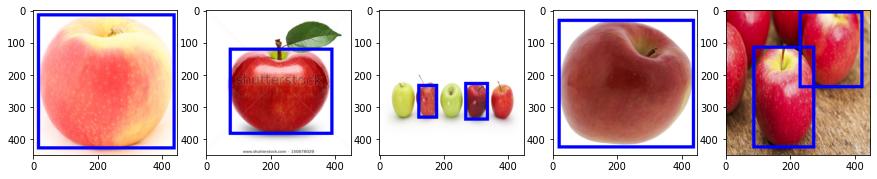

In [10]:
from PIL import ImageDraw

fig, ax = plt.subplots(ncols=5, figsize=(15,10))
ax = ax.flatten()

for i, batch in enumerate(val_dataloader):
    image, targets = batch
    trues = get_true_boxes([batch],
                           grid_size = 7,
                           examples_per_cell = 2,
                           nums_of_classes = 3
                         )
    
    image_back = image[1].permute(1, 2, 0) * cnn_normalization_std + cnn_normalization_mean
    image_back = image_back.permute(2, 0, 1)
    imagePIL = torchvision.transforms.ToPILImage()(image_back)
    draw = ImageDraw.Draw(imagePIL)

    for box in trues[trues[:, 0] == 1]:
        draw.rectangle([(box[1]*448, box[2]*448), (box[3]*448, box[4]*448)], outline='blue', width=10)

    ax[i].imshow(imagePIL)
    if i == 4:
        break

Заметим, что есть фотографии, где bound-box`ов явно не хватает. 

Я перепроверил, что у меня правильно парсятся xml файлы, и что я нигде случайно не теряю bound-box`ы, когда из тензора в полученного в collate_fn ищу таргеты, но не знал как оформить, поэтому не привел. 

Как бы логика поиска была такая: увидел 5 яблок и два бокса, так как у меня val_dataloader без перемешиваний понял, что это 9 элемент в val_dataset. В нем уже сверился, что да это та фотография, и посмотрел на xml файл, и там действительно всего два объекта.

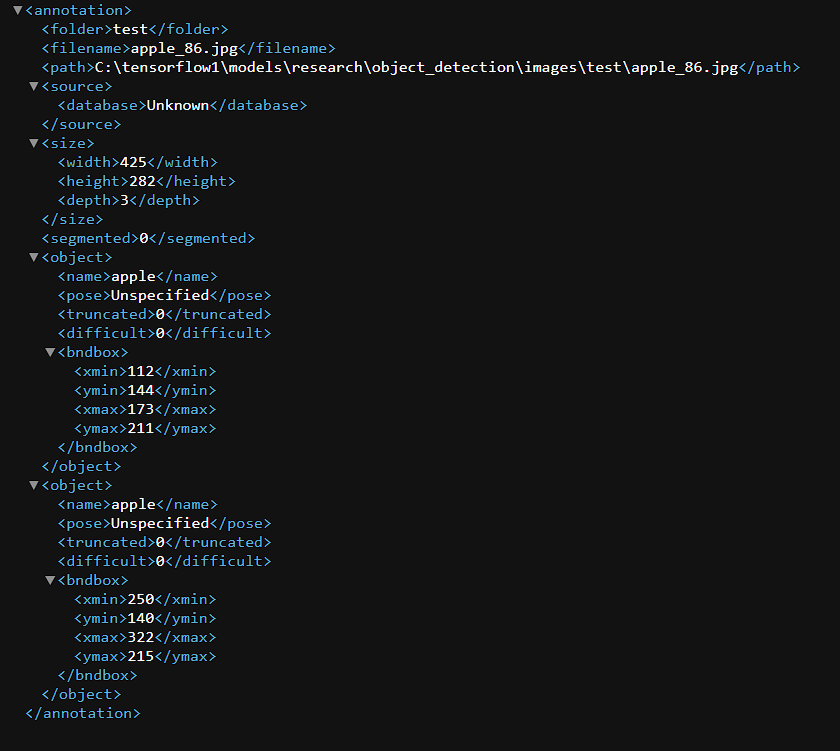

Но ладно val_dataset он все же для финальной проверки, там можно и на глаз сверить 

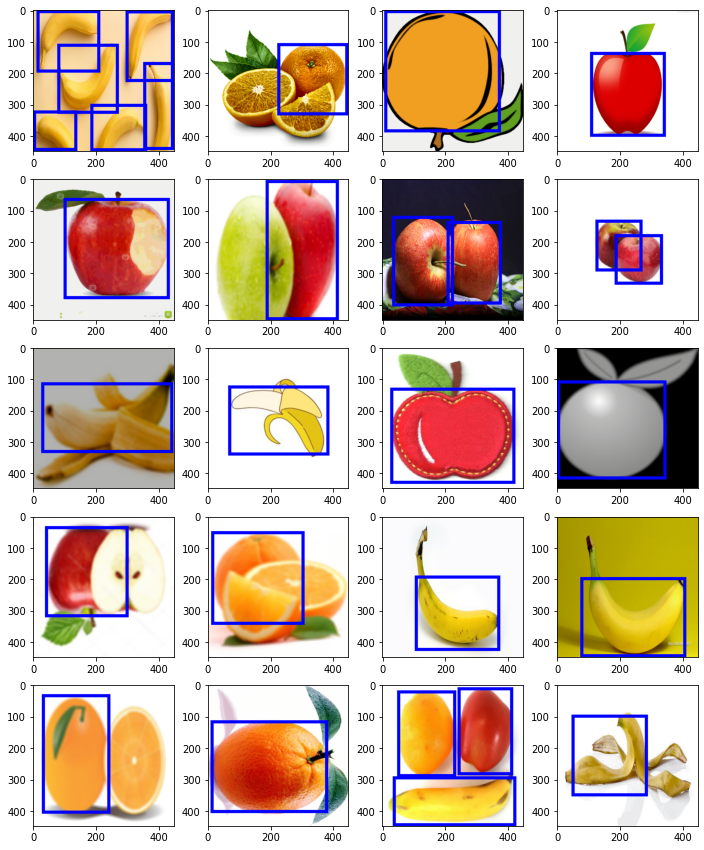

In [146]:
from PIL import ImageDraw

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(12,15))

for i, batch in enumerate(train_dataloader):
    image, targets = batch
    trues = get_true_boxes([batch],
                           grid_size = 7,
                           examples_per_cell = 2,
                           nums_of_classes = 3
                         )
    for j in range(4):
        image_back = image[j].permute(1, 2, 0) * cnn_normalization_std + cnn_normalization_mean
        image_back = image_back.permute(2, 0, 1)
        imagePIL = torchvision.transforms.ToPILImage()(image_back)
        draw = ImageDraw.Draw(imagePIL)

        for box in trues[trues[:, 0] == j]:
            draw.rectangle([(box[1]*448, box[2]*448), (box[3]*448, box[4]*448)], outline='blue', width=10)

        ax[i][j].imshow(imagePIL)
        
    if i == 4:
        break

В трейне виднеется другая проблема: примеры с бананами идут кистью, из-за чего много bound-box`ов, которые друг друга перекрывают, и на глаз бывает тяжело отличить какой box к чему относится.

И остается еще проблема с тем, что bound-box`ы есть не везде, как например с апельсином выше или зеленым яблоком (расизм???).

Но выискивать недоточеты не входило в мои планы, так что будем пытаться обучиться на этом датасете, хотя изначально кажется, что это все будет тяжело, и какой-то высокий скор мы явно не получим.

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [10]:
def intersection_over_union(predicted_bbox, gt_bbox) -> float:
    """
    Intersection Over Union для двух прямоугольников

    :param: dt_bbox - [x_min, y_min, x_max, y_max]
    :param: gt_bbox - [x_min, y_min, x_max, y_max]
    
    :return: Intersection Over Union
    """
    intersection_bbox = torch.Tensor(
        [
            max(predicted_bbox[0], gt_bbox[0]),
            max(predicted_bbox[1], gt_bbox[1]),
            min(predicted_bbox[2], gt_bbox[2]),
            min(predicted_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * B * (5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

In [11]:
class CNNBlock(nn.Module):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):
        
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x
    
class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()

        self.S = S
        self.B = B
        self.C = C

        self.conv1 = nn.Sequential(
            CNNBlock(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, is_max_pool=True), # [64, 112, 112]
            CNNBlock(in_channels=64, out_channels=192, kernel_size=3, padding=1, is_max_pool=True) # [192, 56, 56]
        )

        self.conv2 = nn.Sequential(
            CNNBlock(in_channels=192, out_channels=128, kernel_size=1, is_max_pool=False),
            CNNBlock(in_channels=128, out_channels=256, kernel_size=3, padding=1, is_max_pool=False),
            CNNBlock(in_channels=256, out_channels=256, kernel_size=1, is_max_pool=False),
            CNNBlock(in_channels=256, out_channels=512, kernel_size=3, padding=1, is_max_pool=True), # [512, 28, 28]
        )

        self.conv3 = nn.Sequential(
            CNNBlock(in_channels=512, out_channels=256, kernel_size=1, is_max_pool=False),
            CNNBlock(in_channels=256, out_channels=512, kernel_size=3, padding=1, is_max_pool=False),
            CNNBlock(in_channels=512, out_channels=256, kernel_size=1, is_max_pool=False),
            CNNBlock(in_channels=256, out_channels=512, kernel_size=3, padding=1, is_max_pool=False),
            CNNBlock(in_channels=512, out_channels=256, kernel_size=1, is_max_pool=False),
            CNNBlock(in_channels=256, out_channels=512, kernel_size=3, padding=1, is_max_pool=False),
            CNNBlock(in_channels=512, out_channels=256, kernel_size=1, is_max_pool=False),
            CNNBlock(in_channels=256, out_channels=512, kernel_size=3, padding=1, is_max_pool=False),
            CNNBlock(in_channels=512, out_channels=512, kernel_size=1, is_max_pool=False),
            CNNBlock(in_channels=512, out_channels=1024, kernel_size=3, padding=1, is_max_pool=True) # [1024, 14, 14]
        )

        self.conv4 = nn.Sequential(
            CNNBlock(in_channels=1024, out_channels=512, kernel_size=1, is_max_pool=False),
            CNNBlock(in_channels=512, out_channels=1024, kernel_size=3, padding=1, is_max_pool=False),
            CNNBlock(in_channels=1024, out_channels=512, kernel_size=1, is_max_pool=False),
            CNNBlock(in_channels=512, out_channels=1024, kernel_size=3, padding=1, is_max_pool=False),
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, is_max_pool=False),
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size=3, stride=2, padding=1, is_max_pool=False) # [1024, 7, 7]
        )

        self.conv5 = nn.Sequential(
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, is_max_pool=False),
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, is_max_pool=False) # [1024, 7, 7]
        )


        self.fc = nn.Sequential(
                                nn.Flatten(),
                                nn.Linear(7 * 7 * 1024, 4096),
                                nn.LeakyReLU(0.1, inplace=True),
                                nn.Dropout(0.2, inplace=False),
                                nn.Linear(4096, S * S * (5 * B + C)),
                                nn.Sigmoid()
                            )

        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.fc(x)

        x = x.reshape(-1, self.S, self.S, 5*self.B + self.C)
        
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)



temp_model = YOLO(S=grid_size, B=examples_per_cell, C=nums_of_classes)
expected_output_shape = temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)

assert temp_model(train_dataset[0][0].float().unsqueeze(0)).reshape(-1).shape[0] == expected_output_shape

Когда я писал модель, я вдохновлялся моделью написанной здесь:
* https://github.com/motokimura/yolo_v1_pytorch/blob/master/darknet.py#L163

Тут же используется своя инициализация весов для сверточных слоев в виде **$N(0, \sqrt{\frac{2}{N}})$** , где N - размер взодных векторов. На самом деле двойки в числителе может и не быть, так как это распределение для активации ReLU. Там примерно в двое режутся параметры после активации, так что этим она аргументирована.

Информацию почему следует инициализировать самому веса я находил в итоге здесь:
* https://towardsdatascience.com/understand-kaiming-initialization-and-implementation-detail-in-pytorch-f7aa967e9138
* https://adityassrana.github.io/blog/theory/2020/08/26/Weight-Init.html
* https://jamesmccaffrey.wordpress.com/2018/08/21/pytorch-neural-network-weights-and-biases-initialization/

Кто-то сам не понимает, почему инициализация в ручную лучше срабатывает, а кто-то говорит о баге, где распределенние выглядит как **$N(0, \sqrt{\frac{5}{N}})$** , который выбран так, потому что хорошо работал, но ничем такой выбор больше не подкреплен. Да и на практике с запуском без ручной инициализации график **Loss`а** совсем плохо выглядел...

## Реализуйте YoloLoss - 3 балла

Во время реализации **Loss`а** пользовался следующими материалами, которые обнаружил в сети Интернет:
* https://github.com/motokimura/yolo_v1_pytorch/blob/master/loss.py
* https://www.programmersought.com/article/73454156425/
* https://medium.com/adventures-with-deep-learning/yolo-v1-part3-78f22bd97de4
* https://medium.com/oracledevs/final-layers-and-loss-functions-of-single-stage-detectors-part-1-4abbfa9aa71c

Можно заметить, что моя итоговая реализация сделана как на **GitHub`е** , но с небольшими изменениями. Я её взял за основу, так как она понятна в реализации, и там поясняется каждый шаг, что тяжело найти в других источниках.

In [12]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3, device='cpu'):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

        self.device = device

    def forward(self, predictions, target):
        """ YOLO LOSS
            После батчевальни predictions и target будут иметь следующие размеры
        Args:
            predictions: (Tensor) размер [n_batch, S, S, Bx5+C], 5=len([x, y, w, h, conf]).
            target: (Tensor) размер [n_batch, S, S, Bx5+C].
        Returns:
            (Tensor): loss, sized [1, ].
        """

        batch_size = predictions.shape[0]

        mask_obj = target[:, :, :, 4] > 0 # Маска ячеек, где есть объекты [n_batch, S, S]
        mask_noobj = target[:, :, :, 4] == 0 # Маска ячеек, где объектов нет [n_batch, S, S]

        mask_obj = mask_obj.unsqueeze(-1).expand_as(target) # Распространяем маску на все предикты [n_batch, S, S, Bx5+C]
        mask_noobj = mask_noobj.unsqueeze(-1).expand_as(target) # Распространяем маску на все предикты [n_batch, S, S, Bx5+C]


        predict_obj = predictions[mask_obj].view(-1, self.B*5 + self.C)         # Берем только предикты, где у нас есть объекты. [n_coord, Bx5+C]
                                                                                # n_coord: кол-во ячеек, где есть объекты.
        bbox_pred = predict_obj[:, :5*self.B].contiguous().view(-1, 5)          # Собираем координаты и уверенность ВСЕХ боксов [n_coord x B, 5=len([x, y, w, h, conf])]
        class_pred = predict_obj[:, 5*self.B:]                                  # Собираем распределение вероятности по классам [n_coord, C]

        # Делаем тоже самое, но для таргета
        target_obj = target[mask_obj].view(-1, self.B*5 + self.C)               # [n_coord, Bx5+C]

        bbox_target = target_obj[:, :5*self.B].contiguous().view(-1, 5)         # [n_coord x B, 5=len([x, y, w, h, conf])]
        class_target = target_obj[:, 5*self.B:]                                 # [n_coord, C]

        noobj_pred = predictions[mask_noobj].view(-1, self.B*5 + self.C)                          # Предикты, где нет объектов. [n_noobj, N]
                                                                                                  # n_noobj: кол-во ячеек, где нет объектов.
        noobj_target = target[mask_noobj].view(-1, self.B*5 + self.C)                             # Таргеты, где нет объектов. [n_noobj, N]
                                                                                                  # n_noobj: кол-во ячеек, где нет объектов.
        noobj_conf_mask = torch.zeros(noobj_pred.size(), device=self.device, dtype=torch.bool)    # Вводим тензор маски, который поможет достать значение уверенностей [n_noobj, N]

        for b in range(self.B):
            noobj_conf_mask[:, 4 + b*5] = 1 # noobj_conf_mask[:, 4] = 1; noobj_conf_mask[:, 9] = 1

        noobj_pred_conf = noobj_pred[noobj_conf_mask]       # [n_noobj, 2=len([conf1, conf2])]
        noobj_target_conf = noobj_target[noobj_conf_mask]   # [n_noobj, 2=len([conf1, conf2])]

        loss_noobj = F.mse_loss(noobj_pred_conf, noobj_target_conf, reduction='sum') # Лосс уверенности, где нет объектов

        response_mask_obj =  torch.zeros(bbox_target.size(), device=self.device, dtype=torch.bool)      # [n_coord x B, 5]
        bbox_target_iou = torch.zeros(bbox_target.size(), device=self.device)                           # [n_coord x B, 5]

        # Мы должны выбрать из B боксов тот, у которого будет наивысший IoU с таргетом
        for i in range(0, bbox_target.size(0), self.B):
            pred = bbox_pred[i:i+self.B] # Боксы в i-той ячейке, [B, 5=len([x, y, w, h, conf])]
            pred_xyxy = torch.FloatTensor(pred.size()) # Вспомогательный тензор для переброски из
                                                                 # [B, 5=len([x, y, w, h, conf])] в [B, 5=len([x1, y1, x2, y2, conf])]

            # Так как (center_x,center_y)=pred[:, 2] и (w,h)=pred[:,2:4] нормализованны по размеру ячейки и изображения соответственно,
            # Перемасштабируем (center_x, center_y) под размер картинки, чтобы посчитать IoU корректно.
            # На самом деле это перемасштабирование не выдает настоящие координаты ячейки, так как должно быть по идее смещнение на её номер в сетке, но нас интересует IoU, которому это и не надо будет
            pred_xyxy[:,  :2] = pred[:, :2]/float(self.S) - 0.5 * pred[:, 2:4]
            pred_xyxy[:, 2:4] = pred[:, :2]/float(self.S) + 0.5 * pred[:, 2:4]

            target = bbox_target[i].view(-1, 5) # Так же достаем бокс с тагргета, [1, 5=len([x, y, w, h, conf])]
            target_xyxy = torch.FloatTensor(target.size()) # Вспомогательный тензор для переброски из
                                                                     # [B, 5=len([x, y, w, h, conf])] в [B, 5=len([x1, y1, x2, y2, conf])]
                                                                  
            # Так как (center_x,center_y)=pred[:, 2] и (w,h)=pred[:,2:4] нормализованны по размеру ячейки и изображения соответственно,
            # Перемасштабируем (center_x, center_y) под размер картинки, чтобы посчитать IoU корректно.
            target_xyxy[:,  :2] = target[:, :2]/float(self.S) - 0.5 * target[:, 2:4]
            target_xyxy[:, 2:4] = target[:, :2]/float(self.S) + 0.5 * target[:, 2:4]

            iou = torch.Tensor([intersection_over_union(pred_xyxy[i, :4], target_xyxy[0, :4]) for i in range(self.B)]) # [B, 1]

            max_iou, max_index = iou.max(0)
            max_index = max_index.data.to(self.device)

            response_mask_obj[i+max_index] = 1

            # "We want the confidence score to equal the intersection over union (IOU) between the predicted box and the ground truth"
            # Это по словам авторов статьи про YOLO.
            bbox_target_iou[i + max_index] = (max_iou).data.to(self.device)
        bbox_target_iou = bbox_target_iou.to(self.device)

        # Выбираем боксы, где у нас есть предикт с наибольшим IoU 
        bbox_pred_response = bbox_pred[response_mask_obj].view(-1, 5)      # [n_response, 5]
        bbox_target_response = bbox_target[response_mask_obj].view(-1, 5)  # [n_response, 5], только первые 4=(x, y, w, h) координаты используются
        target_iou = bbox_target_iou[response_mask_obj].view(-1, 5)        # [n_response, 5], только уверенность используется (последний столбец)
        loss_xy = F.mse_loss(bbox_pred_response[:, :2], bbox_target_response[:, :2], reduction='sum')
        # в статье написано, что лучше брать лосс от корней ширины и высоты, чтобы на небольшие изменения (perturbations) больше снижало у мелких боксов, чем у больших
        loss_wh = F.mse_loss(torch.sqrt(bbox_pred_response[:, 2:4]), torch.sqrt(bbox_target_response[:, 2:4]), reduction='sum')
                                                         
        loss_obj = F.mse_loss(bbox_pred_response[:, 4], target_iou[:, 4], reduction='sum')

        loss_class = F.mse_loss(class_pred, class_target, reduction='sum')

        # Итоговый лосс
        loss = self.lambda_coord * (loss_xy + loss_wh) + loss_obj + self.lambda_noobj * loss_noobj + loss_class
        loss = loss / float(batch_size)

        return loss

## Реализуйте дополнительные функции из статьи - 2 балла

Для реализации **non_max_suppression** использовался следующий источник:
* https://medium.com/analytics-vidhya/non-max-suppression-nms-6623e6572536

Для реализации **mean_average_precision** и **get_bound_boxes** я использовал написанный код отсюда:
* https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/object_detection/YOLO/utils.py#L327
Я изменил обработку данных, чтобы потом получать спокойно **mAP**, и также использовать **torch.tensor** , а не **list**.

In [13]:
def non_max_suppression(bboxes, iou_threshold, threshold, device='cpu', grid_size=7, examples_per_cell=2, nums_of_classes=3):
        """ 
        Args:
            bboxes: (Tensor) размер [n_bboxes, 5+C], 5=len([x_min, y_min, x_max, y_max, conf]).
            iou_threshold: (float).
            threshold: (float)
        Returns:
            (List): bboxes_from_batch, sized [n_boxes_i, 9] 9=(len([batch_num, xmin, ymin, xmax, ymax, conf, prob_class1, prob_class2, prob_class3])).
        """
        bboxes_sorted_by_conf = bboxes[bboxes[:, 4].sort(dim=0, descending=True)[1].data] # батчи отсортированы независимо по конфеденсу
        new_bboxes = bboxes_sorted_by_conf[bboxes_sorted_by_conf[:, 4] > threshold]
        i = 0
        while i < len(new_bboxes):
            curr_bbox = new_bboxes[i]
            label = curr_bbox[5:].argmax(dim=0)
            j = i + 1
            while j < len(new_bboxes):
                if label == new_bboxes[j, 5:].argmax(dim=0):
                    iou = intersection_over_union(curr_bbox[:4], new_bboxes[j, :4])
                    if iou > iou_threshold:
                        new_bboxes = torch.cat((new_bboxes[:j], new_bboxes[j+1:]))
                    else:
                        j += 1
                else:
                    j += 1
            i += 1

        return new_bboxes

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, grid_size=7, examples_per_cell=2, nums_of_classes=3, device='cpu', epsilon = 1e-6):
    """
    Parameters:
        pred_boxes (list): содержит боксы вида [n_bboxes, 6+С], 6+С=(len([train_num, xmin, ymin, xmax, ymax, conf, prob_class1, prob_class2, prob_class3, ....]
        true_boxes (list): боксы вида [n_bboxes, 6+С],  
        iou_threshold (float): трешхолд для классификации
    Returns:
        float: значение mAP для определенного  iou_threshold
    """
    average_precisions = []

    for c in range(nums_of_classes):
        detections = []
        ground_truths = []

        # идем через все боксы и берем только нужного класса
        for detection in pred_boxes:
            if detection[6:].argmax(dim=0) == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[6:].argmax(dim=0) == c:
                ground_truths.append(true_box)

        # Тут мы вначале будем хранить кол-во таргет боксов на данной картинке
        amount_bboxes = Counter([gt[0].int().item() for gt in ground_truths])

        # Здесь мы его чуть переобозначим и добавим на каждое изображение столько нулей сколько таргет боксов на этом изображении
        amount_bboxes1 = {}
        for key, val in amount_bboxes.items():
            amount_bboxes1[key] = torch.zeros(val)
        amount_bboxes = amount_bboxes1

        # Отсортируем по уверенности
        detections.sort(key=lambda x: x[5], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # Если таргет боксов данного класса нет, то скипаем
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Берем таргеты с одного изображения
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[1:5]),
                    torch.tensor(gt[1:5])
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
            # print(detection)
            if best_iou > iou_threshold:
                # Так как у нас боксы отсортированы уже, то если к этому таргету уже нашли хороший бокс, то этот отлетает в FP
                if amount_bboxes[detection[0].int().item()][best_gt_idx] == 0:
                    # Добавляем в FP и пишем, что этот таргет бокс уже забит
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0].int().item()][best_gt_idx] = 1 # забит
                else:
                    FP[detection_idx] = 1

            # Тут он отлетает в FP по маленькому IoU
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0) # на i-ой позиции сумма подпоследовательности [0,i]
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon) # очевидно 
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon)) # очевидно по формуле
        precisions = torch.cat((torch.tensor([1]), precisions)) # добавляем изначальная точка для интегрирования 
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz методом трапеций считает площадь под графиком
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


def get_bound_boxes(loader, model, iou_threshold=.5, threshold=.4, grid_size=7, examples_per_cell=2, nums_of_classes=3, device='cpu'):
    """ 
        Args:
            loader: (Tensor) размер [N, n_batches, S, S, 5xB+C], 5=len([x, y, w, h, conf]).
            iou_threshold: (float).
            threshold: (float)
        Returns:
            (List): bboxes_from_batch, sized [n_boxes_i, 9] 9=(len([batch_num, xmin, ymin, xmax, ymax, conf, prob_class1, prob_class2, prob_class3])).
    """
    all_pred_boxes = torch.tensor([], device=device)
    all_true_boxes = torch.tensor([], device=device)

    model.eval()
    train_idx = 0

    for batch_idx, (x, true_boxes) in enumerate(loader):
        x = x.to(device)
        true_boxes = true_boxes.to(device) # [S, S, 5xB+C]

        with torch.no_grad():
            bboxes = model(x.float())

        batch_size = x.shape[0]

        # Приведем true_boxes к виду, где в каждой строке батча таргет бокс
        start_of_last_box_idx = 5*(examples_per_cell-1)
        new_true_boxes = torch.zeros((true_boxes.shape[0], true_boxes.shape[1], true_boxes.shape[2], 5 + nums_of_classes), device=device)
        for i in range(grid_size):
            for j in range(grid_size):
                new_true_boxes[:, i, j, 0] = (true_boxes[:, i, j, 0] + i) / grid_size - 0.5*true_boxes[:, i, j, 2]  # x_min
                new_true_boxes[:, i, j, 1] = (true_boxes[:, i, j, 1] + j) / grid_size - 0.5*true_boxes[:, i, j, 3]  # y_min
                new_true_boxes[:, i, j, 2] = (true_boxes[:, i, j, 0] + i) / grid_size + 0.5*true_boxes[:, i, j, 2]  # x_max
                new_true_boxes[:, i, j, 3] = (true_boxes[:, i, j, 1] + j) / grid_size + 0.5*true_boxes[:, i, j, 3]  # y_max
                new_true_boxes[:, i, j, 4:] = true_boxes[:, i, j, -(1 + nums_of_classes):]                          # conf, probclass1, probclass2,.... 
        
        new_true_boxes = new_true_boxes.view(new_true_boxes.shape[0], -1, 5 + nums_of_classes) # [n_batch, S*S, 5+C]
        true_boxes = new_true_boxes


        # Приведем bboxes к виду, где в каждой строке батча бокс
        bboxes_coord = bboxes[:, :, :, :-nums_of_classes]
        classes = bboxes[:, :, :, -nums_of_classes:]

        # [n_batch, S, S, (xmin, ymin, xmax, ymax, conf)]
        bboxes_xy = torch.zeros(bboxes_coord.shape, device=device)
        for i in range(grid_size):
            for j in range(grid_size):
                for ex in range(examples_per_cell):
                    bboxes_xy[:, i, j, 0+ex*5] = (bboxes_coord[:, i, j, 0+ex*5] + i) / grid_size - 0.5*bboxes_coord[:, i, j, 2+ex*5]  # x_min
                    bboxes_xy[:, i, j, 1+ex*5] = (bboxes_coord[:, i, j, 1+ex*5] + j) / grid_size - 0.5*bboxes_coord[:, i, j, 3+ex*5]  # y_min
                    bboxes_xy[:, i, j, 2+ex*5] = (bboxes_coord[:, i, j, 0+ex*5] + i) / grid_size + 0.5*bboxes_coord[:, i, j, 2+ex*5]  # x_max
                    bboxes_xy[:, i, j, 3+ex*5] = (bboxes_coord[:, i, j, 1+ex*5] + j) / grid_size + 0.5*bboxes_coord[:, i, j, 3+ex*5]  # y_max
                    bboxes_xy[:, i, j, 4+ex*5] = bboxes_coord[:, i, j, 4+ex*5]                                                        # conf

        bboxes_coord = bboxes_xy.view(bboxes_coord.shape[0], -1, 5)  # [n_batch, n_bboxes, 5], 5=(len([xmin, ymin, xmax, ymax, conf]))
        classes = classes.view(bboxes_coord.shape[0], -1, nums_of_classes) # [n_batch, n_bboxes // B, nums_of_classes], nums_of_classes=(len([prob_class1, prob_class2, prob_class3, ...]))
        
        new_classes = torch.zeros((bboxes_coord.shape[0], bboxes_coord.shape[1], classes.shape[2]), device=device)
        for i in range(0, bboxes_coord.shape[1], examples_per_cell):
            new_classes[:, i, :] = classes[:, i // examples_per_cell, :]
            new_classes[:, i+1, :] = classes[:, i // examples_per_cell, :]

        bboxes = torch.cat((bboxes_coord, new_classes), -1) # [n_batch, n_bboxes, 5 + nums_of_classes]

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                device=device,
                grid_size=7,
                examples_per_cell=2,
                nums_of_classes=3
            )

            if nms_boxes.any():
                nms_boxes = torch.cat((torch.tensor([[train_idx]]*nms_boxes.shape[0], device=device), nms_boxes), dim=1)
                all_pred_boxes = torch.cat((all_pred_boxes, nms_boxes), dim=0)

            # убираем нулевые боксы
            mask_true_bbox = true_boxes[idx, :, 4] > 0 # [S*S]
            mask_true_bbox = mask_true_bbox.unsqueeze(-1).expand_as(true_boxes[idx]) # [S*S, 5+C]

            batch_true_boxes = true_boxes[idx][mask_true_bbox].view(-1, 5+nums_of_classes)   # Берем только таргеты, где у нас есть объекты. [n_bboxes, 5+C]
            batch_true_boxes = torch.cat((torch.tensor([[train_idx]]*batch_true_boxes.shape[0], device=device), batch_true_boxes), dim=1)
            all_true_boxes = torch.cat((all_true_boxes, batch_true_boxes), dim=0)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [14]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

def train(model, optimizer, criterion, scheduler, train_loader, test_loader, num_epochs=100):
    '''
        params:
            model - torch.nn.Module to be fitted
            optimizer - model optimizer
            criterion - loss function from torch.nn
            train_loader - torch.utils.data.Dataloader with train set
            test_loader - torch.utils.data.Dataloader with test set
                          (if you wish to validate during training)
    '''
    train_history = []
    test_history = []
    best_loss = np.inf

    for e in range(num_epochs):
        history = []
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader):
            features, label = batch
            features, label = features.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(features.float())
            loss = criterion(output, label.to(device))
            train_loss += loss.item()
            history.append(loss.item())
            loss.backward()
            optimizer.step()
        
        
        train_history.append(train_loss / (len(train_dataset) // 4))
        test_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in tqdm(test_loader):
                features, label = batch
                features, label = features.to(device), label.to(device)
                output = model(features.float())
                loss = criterion(output, label.to(device))
                test_loss += loss.item()
        
        scheduler.step()
        
                
        if test_loss / (len(val_dataset) // 4) < best_loss:
            best_loss = test_loss / (len(val_dataset) // 4)
            torch.save(model.state_dict(), 'model.pth')
            

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
        
        test_history.append(test_loss / (len(val_dataset) // 4))

        clear_output(True)
        ax[0].plot(history, label='train loss')
        ax[0].set_xlabel('Batch')
        ax[0].set_title('Train loss')
        if train_history is not None:
            ax[1].plot(train_history, label='general train history')
            ax[1].set_xlabel('Epoch')
        if test_history is not None:
            ax[1].plot(test_history, label='general test history')
        plt.legend()

        plt.show()
                
        print(f"Train Loss: {train_loss / (len(train_dataset) // 4):.4f}, "
              f"Test Loss: {test_loss / (len(val_dataset) // 4):.4f}, "
              f"Best Test Loss: {best_loss:.4f}, "
              f"Number of epoch: {e + 1}")
        
        

In [34]:
seed_everything(123)
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 300

model = YOLO(S=grid_size, B=examples_per_cell, C=nums_of_classes).to(device)
loss = YoloLoss(S=grid_size, B=examples_per_cell, C=nums_of_classes, device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.3, step_size=100)


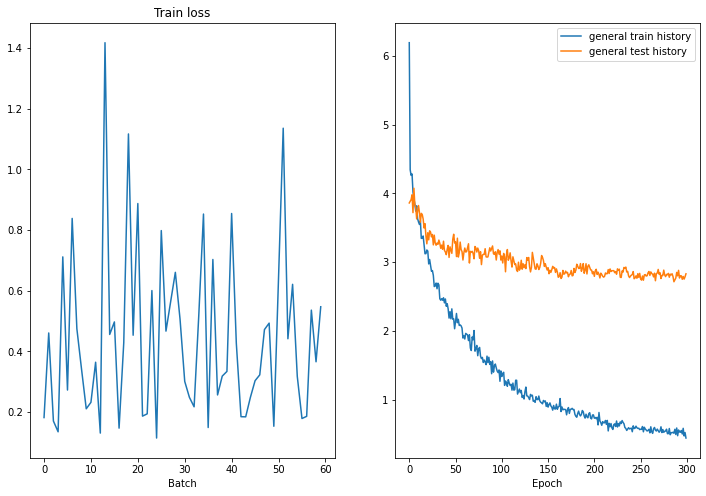

Train Loss: 0.4421, Test Loss: 2.8312, Best Test Loss: 2.7157, Number of epoch: 300


In [35]:
train(model, optimizer, loss, scheduler, train_dataloader, val_dataloader, num_epochs)

## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

In [36]:
def testing(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    test_loss = 0
    mAP = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader):
            features, label = batch
            features, label = features.to(device), label.to(device)
            output = model(features.float())
            loss = criterion(output, label.to(device))
            pred_boxes, true_boxes = get_bound_boxes([batch],
                                                      model,
                                                      iou_threshold=.5,
                                                      threshold=.2,
                                                      grid_size = 7,
                                                      examples_per_cell = 2,
                                                      nums_of_classes = 3,
                                                      device=device)
            test_loss += loss.item()
            mAP += mean_average_precision(pred_boxes,
                                          true_boxes,
                                          iou_threshold=0.5,
                                          grid_size = 7,
                                          examples_per_cell = 2,
                                          nums_of_classes = 3,
                                          device=device,
                                          epsilon = 1e-6)
    
    
            
    print(f"Test Loss: {test_loss / (len(val_dataset) // 4)}")
    print(f"mAP : {mAP / (len(val_dataset)) * 100}")
    

In [28]:
model.load_state_dict(torch.load('/kaggle/working/model.pth'))

<All keys matched successfully>

In [37]:
testing(model, loss, val_dataloader)

  0%|          | 0/15 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test Loss: 3.163361203670502
mAP : 11.648608207702637


## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

In [38]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

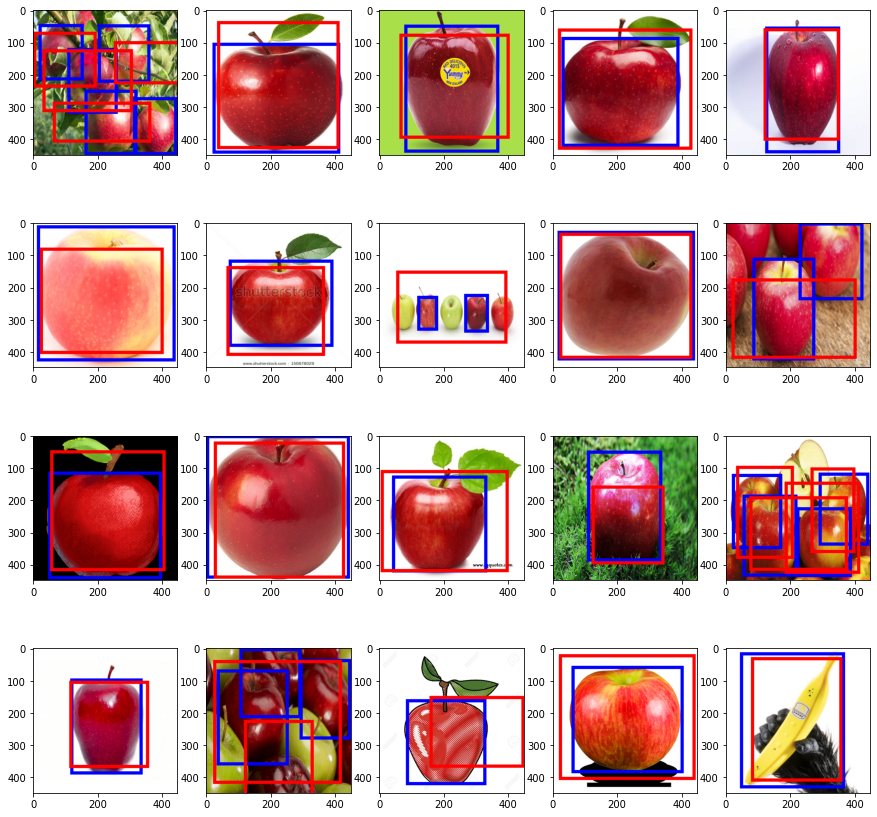

In [71]:
from PIL import ImageDraw

fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,15))

for i, batch in enumerate(val_dataloader):
    image, targets = batch

    preds, trues = get_bound_boxes([batch],
                                   model,
                                   iou_threshold=.3,
                                   threshold=.2,
                                   grid_size = 7,
                                   examples_per_cell = 2,
                                   nums_of_classes = 3,
                                   device=device)
    
    for j in range(4):
        image_back = image[j].permute(1, 2, 0) * cnn_normalization_std + cnn_normalization_mean
        image_back = image_back.permute(2, 0, 1)
        imagePIL = torchvision.transforms.ToPILImage()(image_back)
        draw = ImageDraw.Draw(imagePIL)

        for box in trues[trues[:, 0] == j]:
            draw.rectangle([(box[1]*448, box[2]*448), (box[3]*448, box[4]*448)], outline='blue', width=10)

        for box in preds[preds[:, 0] == j]:
            draw.rectangle([(box[1]*448, box[2]*448), (box[3]*448, box[4]*448)], outline='red', width=10)

        ax[j][i].imshow(imagePIL)
        
    if i == 4:
        break

Нууу предсказывает он, будем честны, плохо, но у меня так долго всё не запускалось, ломалось, не сходилось, что я даже такому результату очень сильно рад. 

Давайте посмотрим как он себя показывает на трейне для интереса.

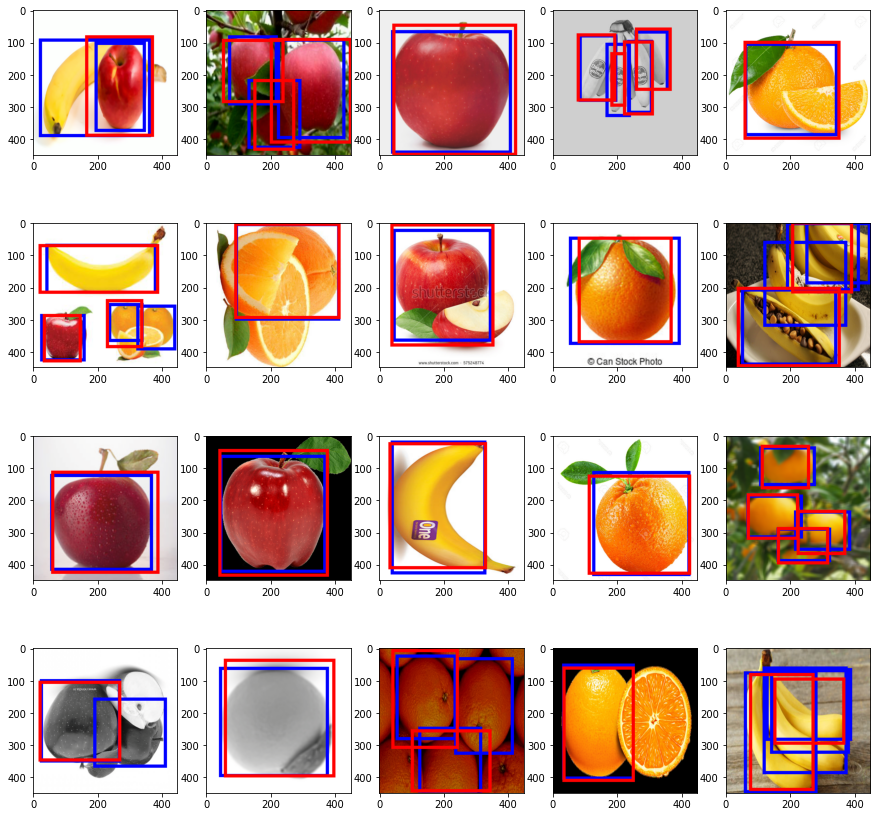

In [42]:
from PIL import ImageDraw

fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,15))

for i, batch in enumerate(train_dataloader):
    image, targets = batch

    preds, trues = get_bound_boxes([batch],
                                   model,
                                   iou_threshold=.3,
                                   threshold=.3,
                                   grid_size = 7,
                                   examples_per_cell = 2,
                                   nums_of_classes = 3,
                                   device=device)
    
    for j in range(4):
        image_back = image[j].permute(1, 2, 0) * cnn_normalization_std + cnn_normalization_mean
        image_back = image_back.permute(2, 0, 1)
        imagePIL = torchvision.transforms.ToPILImage()(image_back)
        draw = ImageDraw.Draw(imagePIL)

        for box in trues[trues[:, 0] == j]:
            draw.rectangle([(box[1]*448, box[2]*448), (box[3]*448, box[4]*448)], outline='blue', width=10)

        for box in preds[preds[:, 0] == j]:
            draw.rectangle([(box[1]*448, box[2]*448), (box[3]*448, box[4]*448)], outline='red', width=10)

        ax[j][i].imshow(imagePIL)
        
    if i == 4:
        break

Да, тут он натренировался на датасете видно (ещё бы не натренировался) - результаты лучше чем на валидации.